In [ ]:
sys.path.append('/Users/jacoblourie')

In [41]:
import tensorflow as tf
import sys
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
#From my own library
from computer_vision.my_lib.blur_contrast import display_image
import pandas as pd

## Trying to build a full 3 layer neural net from scratch using MNIST data

In [6]:
#Load the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_train, x_test = x_train / 255.0, x_test / 255.0

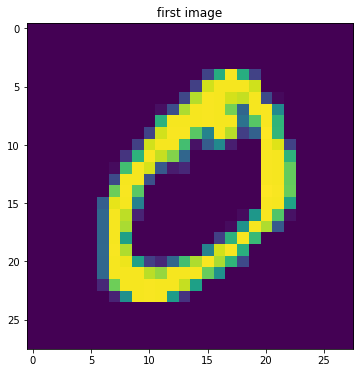

In [7]:
#see what an image looks like
display_image(x_train[1],'first image', size=(6,6))

We want to run a 1/0 model, so let's label all "1"s as 1, and everything else as 0

In [19]:
binary_y_train = np.array([1 if 1 else 0 for y in y_train])
binary_y_test = np.array([1 if 1 else 0 for y in y_test])

Let's go for 2 hidden layers, of 50 and 50 levels and let's just use sigmoid functions for now

In [20]:
#this helps much simpler
x_train_flat = x_train.reshape((60000,-1)).T / 255
x_test_flat = x_test.reshape((10000,-1)).T / 255
print(x_test_flat.shape)
y_train_transp = y_train.reshape(1,-1) 
y_test_transp = y_test.reshape(1,-1)

#Create the binary model
bin_y_train = binary_y_train.reshape(1,-1)
bin_y_test = binary_y_test.reshape(1,-1)


(784, 10000)


In [21]:
#Let's create the 'weights' matrices
np.random_state = 112
layer_1 = 50
layer_2 = 50
size_of_layer = [x_train_flat.shape[0], layer_1,layer_2, 1]
dict_of_weights = {}

for layer in range(len(size_of_layer) - 1):
    dict_of_weights[f"W{layer+1}"] = np.random.randn(size_of_layer[layer+1],size_of_layer[layer])
    dict_of_weights[f"B{layer+1}"] = np.random.randn(size_of_layer[layer+1],1)
#Print the sizes of the matrix
print(f"Weights matrices")
for name, matrix in dict_of_weights.items():
    print(name, matrix.shape)


Weights matrices
W1 (50, 784)
B1 (50, 1)
W2 (50, 50)
B2 (50, 1)
W3 (1, 50)
B3 (1, 1)


OK we've gone with a gaussian initialisation of the matrices. We'll come back to this

In [22]:

def sigmoid(x):
    return (1/(1+np.exp(-x)))

dict_of_FP_values = {}
#FORWARD PROPOGATION
def forward_prop(dict_of_weights,x_train_flat):

    #let's create the first level
    Z1 = dict_of_weights['W1'] @ x_train_flat + dict_of_weights['B1']
    A1 = sigmoid(Z1)

    #Then second level
    Z2 = dict_of_weights['W2'] @ A1 + dict_of_weights['B2']
    A2 = sigmoid(Z2)

    #Then output level

    Z3 = dict_of_weights['W3'] @ A2 + dict_of_weights['B3']
    A3 = sigmoid(Z3)

    dict_of_FP_values['Z1'] = Z1
    dict_of_FP_values['A1'] = A1
    dict_of_FP_values['Z2'] = Z2
    dict_of_FP_values['A2'] = A2
    dict_of_FP_values['Z3'] = Z3
    dict_of_FP_values['A3'] = A3

    Cost = ((bin_y_train - A3) @ np.transpose(bin_y_train - A3) / A3.size )[0]

    return dict_of_FP_values, Cost

dict_of_FP_values, Cost = forward_prop(dict_of_weights,x_train_flat)

#Now let's create the cost function

In [23]:
Z3.shape

NameError: name 'Z3' is not defined

## Great, so now we need to do back propogation.

differential of sigmoid is 

Worth nothing, that everything is positive - this kind of makes sense because right now the dumb model can be improved by just setting everything to 0 (as only 10% of outputs are "1")

Let's keep going back through the differentials

In [24]:
differentiat_dict = {} #putting this here for later

In [25]:

def back_prop(dict_of_weights, dict_of_FP_values, bin_y_train):
    W1, B1, W2, B2, W3, W3 = dict_of_weights.values()
    Z1, A1, Z2, A2, Z3, A3 = dict_of_FP_values.values()
    differentiat_dict = {}
    
    '''Let's look at W3 and B3 first'''
    #dC / dB = dC/dA * dA/dZ * dZ / dB
    #dC / dW = dC/dA * dA/dZ * dZ / dW

    #GO BACK ONE LAYER
    dC_dA3 = 2*(A3 - bin_y_train)/A3.size #gives 1 by m matrix
    dA3_dZ3 = np.exp(-Z3) / ((1+np.exp(-Z3))**2) #still gives 1 x m matrix
    dC_dZ3 = dC_dA3 * dA3_dZ3 #still a 1 x m matirx

    #Get differentials at first layer
    dZ3_dW3 = A2 #should be a 50 x m matrix (all a values)
    dZ3_dB3 = np.zeros_like((Z3)) + 1 #we need a 1 x m matrix

    '''First useful differentials'''
    dC_dW3 = dC_dZ3 @ dZ3_dW3.T 
    dC_dB3 = dC_dZ3 @ dZ3_dB3.T


    '''Now go back, get the dC/dA2 and the repeat the above'''

    #dC / dA2 ~ dC/DZ3 * dZ3 / dA2
    dZ3_dA2 =  W3 # z = WA + b. 1 x 50
    dC_dA2 = (dC_dZ3.T @ dZ3_dA2).T #50 rows, each column is back to being a training example, and there are W2.column_size rows.

    #then repeat the back_prop from before
    dA2_dZ2 = np.exp(-Z2) / ((1+np.exp(-Z2))**2) #still gives 50 x m
    dC_dZ2 = dC_dA2 * dA2_dZ2 #still a 50 x m

    dZ2_dW2 = A1 # which is now 50 x m (A1 also 50 x m)
    dZ2_dB2 = np.zeros_like((Z2)) + 1 #we need a 50 x 1 matrix

            #SECOND USEFUL DIFFERENTIALS
    dC_dW2 = dC_dZ2 @ dZ2_dW2.T  #W2 is 50x 50. dC_dZ2 is a 50 x m , by dz2_dw2 which is a 50xm, but tranpose
    dC_dB2 = np.sum(dC_dZ2 @ dZ2_dB2.T,axis=1,keepdims=True)

    '''#Then let's go back and get the next layer'''

    dZ2_dA1 =  W2 # z = WA + b. 1 x 50
    dC_dA1 = (dC_dZ2.T @ dZ2_dA1).T #50 rows, each column is back to being a training example, and there are W1.column_size rows.

    #then repeat the back_prop from before
    dA1_dZ1 = np.exp(-Z1) / ((1+np.exp(-Z1))**2) #still gives 50 x m
    dC_dZ1 = dC_dA1 * dA1_dZ1 #still a 50 x m

    dZ1_dW1 = x_train_flat # which is now 50 x m (A1 also 50 x m)
    dZ1_dB1 = np.zeros_like((Z1)) + 1 #we need a 50 x 1 matrix

            #THIRD USEFUL DIFFERENTIALS
    dC_dW1 = dC_dZ1 @ dZ1_dW1.T  #W2 is 50x 50. dC_dZ2 is a 50 x m , by dz2_dw2 which is a 50xm, but tranpose
    dC_dB1 = np.sum(dC_dZ1 @ dZ1_dB1.T,axis=1,keepdims=True)

    #add this to the dictionary for later use.
    differentiat_dict['dW1'] = dC_dW1
    differentiat_dict['dB1'] = dC_dB1
    differentiat_dict['dW2'] = dC_dW2
    differentiat_dict['dB2'] = dC_dB2
    differentiat_dict['dW3'] = dC_dW3
    differentiat_dict['dB3'] = dC_dB3

    return differentiat_dict

differentiat_dict = back_prop(dict_of_weights, dict_of_FP_values, bin_y_train)

## Great stuff, now we need to update the weights.

In [62]:
def gradient_descent(learning_rate, dict_of_weights, differentiat_dict):
    
    #we have dictionaries for the weights and the differentials, which we should be able to use quite easily here. They are also in order so we can kind of cheat... but let's not 
    for key, value in dict_of_weights.items():
        dict_of_weights[key] += -learning_rate * differentiat_dict[f'd{key}']

learning_rate = 0.1  #no idea if this is a good learning rate
gradient_descent(learning_rate, dict_of_weights, differentiat_dict)

## SO, now let's run this in a loop and see what happens to Cost

In [65]:
#We start with forward propogation, storing the cost
learning_rate = 0.2 #set an arbitrary learning rate... we can iterate and try a few others soon
iterations = 50
cost = []

for iteration in range(iterations):
    
    dict_of_FP_values, Cost = forward_prop(dict_of_weights,x_train_flat)
    cost.append(Cost[0]) #add cost to the list.
    #then, do back prop, storing the differentials
    differentiat_dict = back_prop(dict_of_weights, dict_of_FP_values, bin_y_train)

    #then, do the gradient descent. Nothing stored, the weights just update and we re-use the new values in forward prop.
    gradient_descent(learning_rate, dict_of_weights, differentiat_dict)


/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

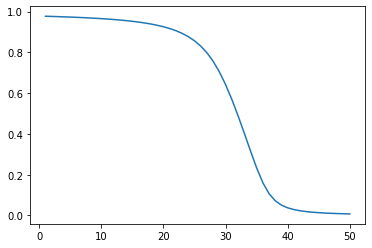

In [90]:
cost_x = np.linspace(1,iterations,iterations)
fig = plt.figure(figsize = (6,4))
sns.lineplot(cost_x,cost)


<AxesSubplot:ylabel='Count'>

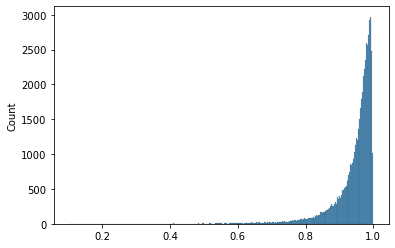

In [89]:
sns.histplot(dict_of_FP_values['A3'][0])